In [1]:
# %pip install gymnasium
# %pip install gymnasium[atari]
# %pip install autorom[accept-rom-license]

In [2]:
import random

import cv2
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from gymnasium.core import ObservationWrapper
from gymnasium.core import Wrapper
from gymnasium.spaces.box import Box
from keras.layers import Conv2D, Dense, Flatten


class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * Crop image, remove irrelevant parts.
        #  * Resize image to self.img_size. Use cv2.resize or any other library you want,
        #    e.g. PIL or Keras. Do not use skimage.transform.resize because it is roughly
        #    6x slower than cv2.resize.
        #  * Cast image to grayscale.
        #  * Convert image pixels to (0, 1) range, float32 type.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img[15:-10, 3:160]
        img = cv2.resize(img, dsize=self.img_size)
        img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return img[..., np.newaxis].astype(np.float32)


class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset()[0])
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info, _ = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis=axis)

In [3]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env


env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

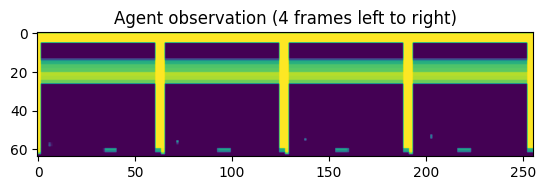

In [4]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([state_dim[0], -1]));

In [5]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
tf.reset_default_graph()
sess = tf.InteractiveSession()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            self.model = tf.keras.Sequential()
            self.model.add(Conv2D(16, (3, 3), strides=2, activation='relu', input_shape=state_shape))
            self.model.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
            self.model.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
            self.model.add(Flatten())
            self.model.add(Dense(256, activation='relu'))
            self.model.add(Dense(n_actions, activation='linear'))

            self.state_t = tf.placeholder('float32', [None, ] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)

        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        # < apply your network layers here >

        qvalues = self.model(state_t)

        # qvalues = < symbolic tensor for q-values >

        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions

        return qvalues

    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p=[1 - epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [7]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

In [8]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break

        rewards.append(reward)
    return np.mean(rewards)

In [9]:
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones)
        )

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [
            random.randint(0, len(self._storage) - 1)
            for _ in range(batch_size)
        ]
        return self._encode_sample(idxes)

In [10]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time
    """
    state = env.framebuffer
    reward = 0
    for _ in range(n_steps):

        qvalues = agent.get_qvalues([state])
        action = agent.sample_actions(qvalues)[0]
        state_next, rew, done, _ = env.step(action)

        exp_replay.add(state, action, reward, state_next, done)
        reward += rew
        if done:
            state = env.reset()
        else:
            state = state_next
    return reward


In [11]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [12]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)

In [13]:
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

In [14]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

In [15]:
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)
reference_qvalues = rewards_ph + gamma * next_state_values_target * is_not_done

td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [18]:
exp_replay = ReplayBuffer(10 ** 5)
play_and_record(agent, env, exp_replay, n_steps=10000)


def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph: obs_batch, actions_ph: act_batch, rewards_ph: reward_batch,
        next_obs_ph: next_obs_batch, is_done_ph: is_done_batch
    }

buffer size = 100000, epsilon = 0.14819


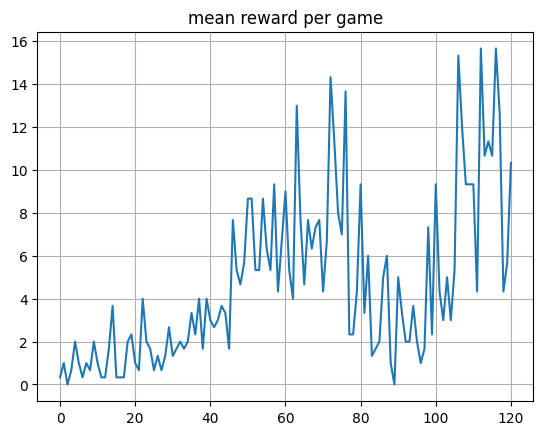

100%|██████████| 10000/10000 [09:47<00:00, 17.03it/s]


In [24]:
for i in trange(10_000):

    play_and_record(agent, env, exp_replay, 10)

    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=128))
    td_loss_history.append(loss_t)

    if i % 500 == 0:
        load_weigths_into_target_network(agent, target_network)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))

    if i % 500 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()
        plt.show()

In [25]:
print(np.mean(mean_rw_history[-10:]))
assert np.mean(mean_rw_history[-10:]) > 10.
print("That's good enough for tutorial.")

10.133333333333333
That's good enough for tutorial.
